# Data Science Project: Artist Style Classification
50.038 Computational Data Science

By:
Lee Chien Shyong 1005903
Khoo Zi Qi 1006984

### 1. Dataset Selection and Collection
**Dataset Type:** Image dataset  
**Source:** Scraped from [Danbooru](https://danbooru.donmai.us/)  

We collected artworks from three specific artists using `gallery-dl`, a Python-based scraper. The dataset consists of high-quality images labeled with artist names.  

#### Scraping Process 
We used the following command to scrape images:  
```bash
gallery-dl "https://danbooru.donmai.us/posts?tags=<artist_name>+rating:general"
```
To filter images and ensure data consistency, we preprocessed the dataset by:  
- Removing corrupted or incorrectly labeled images  
- Standardizing image dimensions  
- Organizing images into directories by artist name  



### 2. Problem Statement
The goal of this project is to **understand and classify artist styles**. Specifically, we aim to:  
- Identify **visual patterns** that make an artist's style unique  
- Train a model to **distinguish between artworks** from different artists  
- Explore why **certain artistic features** are more recognizable than others  



### Baseline Model: Image Classification using Keras
We implement a **naïve model** inspired by the **Keras Tutorial: Image Classification from Scratch** (Week 6 Lab).  

#### Approach:
- Use `image_dataset_from_directory` to load and preprocess the dataset  
- Train a CNN model **from scratch**, similar to the **Kaggle Cats vs Dogs** dataset  
- Apply **image augmentation** to improve model generalization  


#### Dataset Preprocessing

In [ ]:
# Install the required packages
%pip install -r requirements.txt

In [2]:
#Set-up
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.preprocessing import image_dataset_from_directory # type: ignore

In [3]:
import os

# Path to dataset
dataset_path = "gallery-dl/danbooru/"

# Get folder names
artist_folders = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])

print(os.listdir(dataset_path))

['mery_(yangmalgage) rating_general', 'torino_aqua rating_general', 'yukie_(kusaka_shi) rating_general']


In [4]:
num_skipped = 0
for folder_name in artist_folders:
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


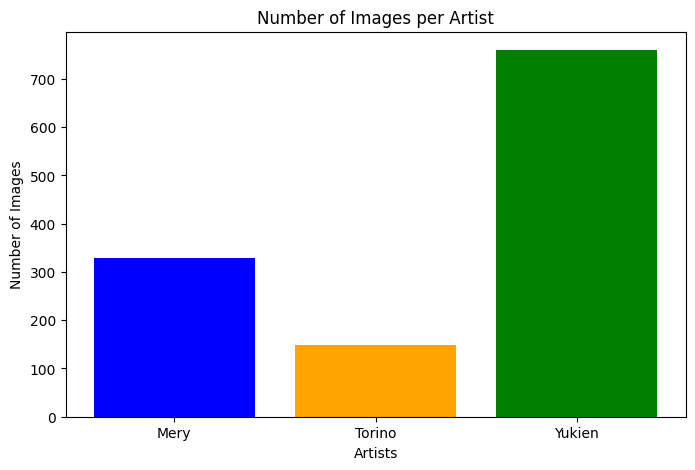

In [5]:
import os
import matplotlib.pyplot as plt

# Define artist labels manually
artist_labels = {0: "Mery", 1: "Torino", 2: "Yukien"}

# Count images per artist
image_counts = [len(os.listdir(os.path.join(dataset_path, folder))) for folder in artist_folders]

# Rename x-axis labels using dictionary
artist_names = [artist_labels[i] for i in range(len(artist_folders))]  # Convert indices to names

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(artist_names, image_counts, color=['blue', 'orange', 'green'])
plt.xlabel("Artists")
plt.ylabel("Number of Images")
plt.title("Number of Images per Artist")
# plt.xticks(rotation=15)
plt.show()


In [ ]:
# TODO: Oversampling: since the dataset is imbalanced

In [52]:
# Generate dataset
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "gallery-dl/danbooru/",
    validation_split=0.2,
    subset="both",
    seed=1,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1238 files belonging to 3 classes.
Using 991 files for training.
Using 247 files for validation.


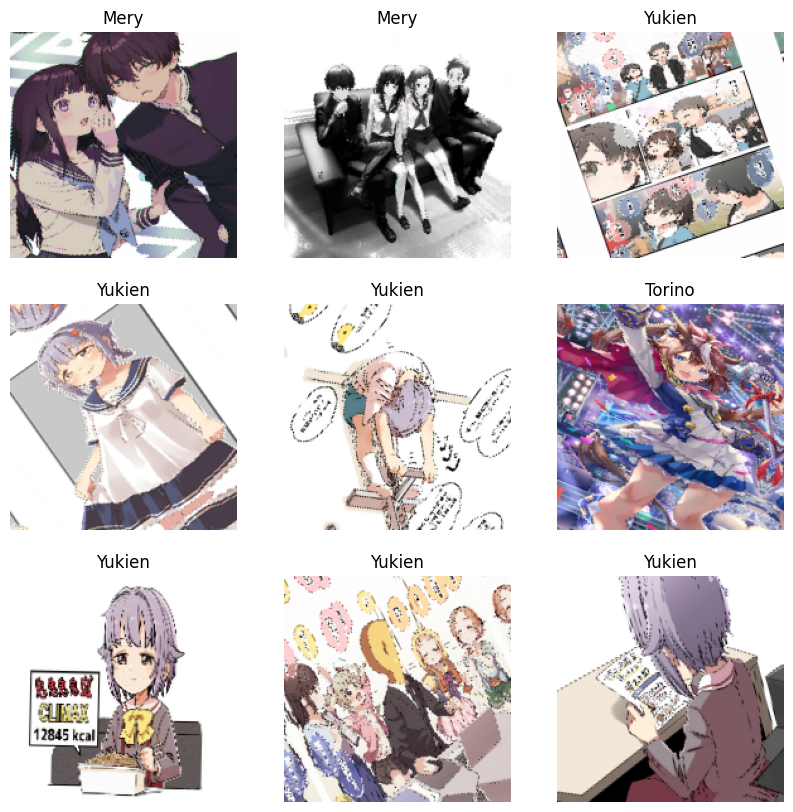

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(artist_labels[int(labels[i])])  # Show artist name instead of number
        plt.axis("off")


In [73]:
tf.random.set_seed(1)

data_augmentation = keras.Sequential(
    [
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    ]
)
# Images are fed to this class and are flipped horizontally followed by a random rotation.
# We also zoom in the images by 20% randomly.

In [74]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

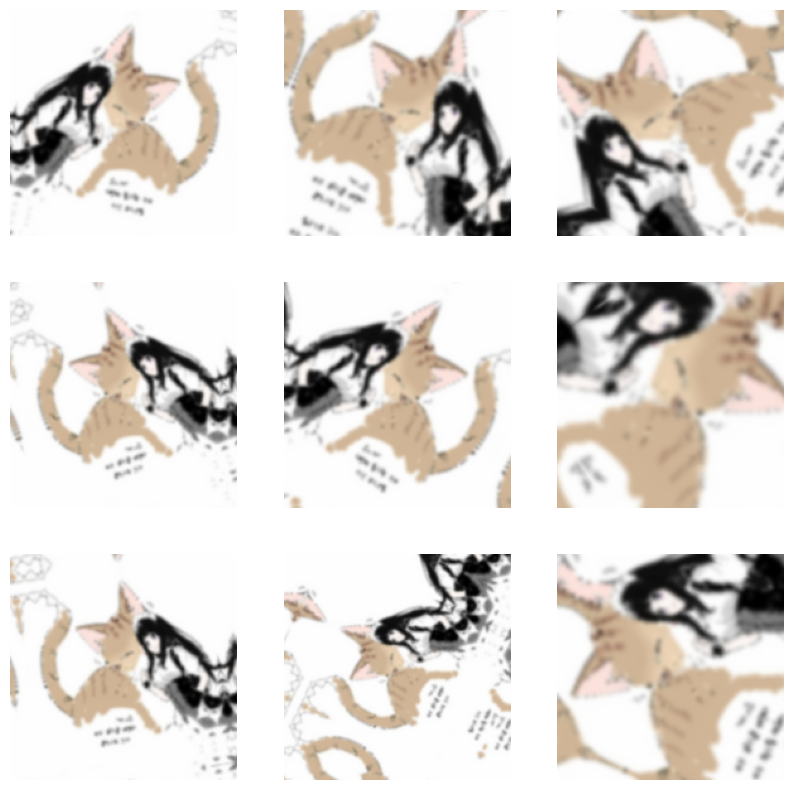

In [75]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): # return one batch of images: 128
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Building the Model


In [76]:
from tensorflow.keras.layers import Dropout # type: ignore
#  can try to optimize the architecture;
#  if you want to do a systematic search for the best model configuration, consider using KerasTuner.
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Flatten()(x)
    # Write dense layers with non-linear activation here.
    x = layers.Dense(392, activation="relu")(x)
    Dropout(0.3),  # Add Dropout to prevent overfitting
    x = layers.Dense(196, activation="relu")(x)
    Dropout(0.3),  # Add Dropout

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes # num_class would be different for MNIST.


    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
# plot_model(model, show_shapes=True)

#### Training the Model


In [77]:
epochs = 5

# Compile model with the correct loss function
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",  # Corrected loss function for MNIST
    metrics=["accuracy"],
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=1,
        restore_best_weights=True  # Restore best weights when stopping early
    ),
]

# Train model
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5175 - loss: 6.5426 - val_accuracy: 0.6316 - val_loss: 1.0343
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4844 - loss: 2.2291 - val_accuracy: 0.6316 - val_loss: 1.9164
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5127 - loss: 2.3009 - val_accuracy: 0.6316 - val_loss: 1.8971
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4842 - loss: 1.8078 - val_accuracy: 0.2348 - val_loss: 1.2704
